In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, GlobalMaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn

Using TensorFlow backend.
/home/greg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/greg/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "cats_vs_dogs.h5"

# Data
path = "/home/greg/datasets/cats_and_dogs/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "test" # 12 500

In [3]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [4]:
# CNN EfficientNet (https://arxiv.org/abs/1905.11946)

model = Sequential()
efficient_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
#efficient_net.trainable = False
for index, layer in enumerate(efficient_net.layers):
    if index < 761:
        layer.trainable = False

    print(index)
    print(layer)
model.add(efficient_net)
#model.add(GlobalMaxPooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Flatten())
# if dropout_rate > 0:
#     model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(Dense(1, activation='sigmoid')) #, name="output"
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f1890541c88>
25
26
27
28
29
30
31
32
33
34
35
36
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f18902c6f28>
37
38
39
40
41
42
43
44
45
46
47
48
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f1890066dd8>
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f184c787dd8>
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f184c45e710>
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f184c0d1dd8>
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f182c564710>
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
<e

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [6]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


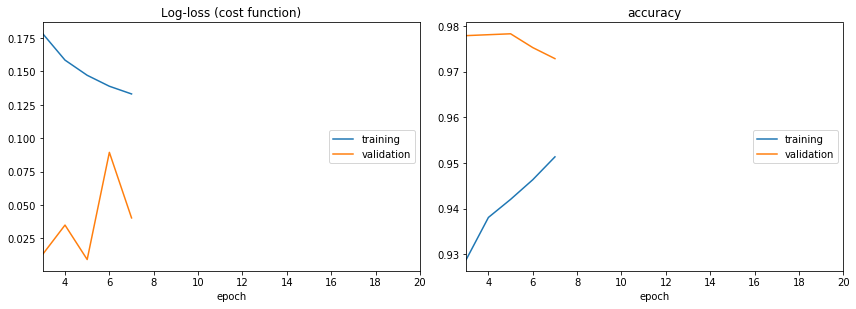

Log-loss (cost function):
training   (min:    0.133, max:    0.258, cur:    0.133)
validation (min:    0.009, max:    0.134, cur:    0.040)

accuracy:
training   (min:    0.891, max:    0.951, cur:    0.951)
validation (min:    0.966, max:    0.978, cur:    0.973)
Epoch 8/20
624/625 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9514

In [ ]:
# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)
model.save_weights(MODEL_FILE)

In [ ]:
# Testing
probabilities = model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()